# Features
**Application_record**
1. `ID` -> Client number	
2. `CODE_GENDER` -> Gender	
3. `FLAG_OWN_CAR` -> Is there a car	
4. `FLAG_OWN_REALTY` -> Is there a property	
5. `CNT_CHILDREN` -> Number of children	
6. `AMT_INCOME_TOTAL` -> Annual income	
7. `NAME_INCOME_TYPE` -> Income category	
8. `NAME_EDUCATION_TYPE` -> Education level	
9. `NAME_FAMILY_STATUS` -> Marital status	
10. `NAME_HOUSING_TYPE` -> Way of living	
11. `DAYS_BIRTH` -> Birthday, Count backwards from current day (0), -1 means yesterday
12. `DAYS_EMPLOYED` -> Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
13. `FLAG_MOBIL` -> Is there a mobile phone	
14. `FLAG_WORK_PHONE` -> Is there a work phone	
15. `FLAG_PHONE` -> Is there a phone	
16. `FLAG_EMAIL` -> Is there an email	
17. `OCCUPATION_TYPE` -> Occupation	
18. `CNT_FAM_MEMBERS` -> Family size

**Credit_record**
1. `ID` -> Client number	
2. `MONTHS_BALANCE` -> Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
3. `STATUS` -> Status	
        0: 1-29 days past due 
        1: 30-59 days past due 
        2: 60-89 days overdue 
        3: 90-119 days overdue 
        4: 120-149 days overdue 
        5: Overdue or bad debts, write-offs for more than 150 days 
        C: paid off that month 
        X: No loan for the month

# Import Library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# traintest split
from sklearn.model_selection import train_test_split, cross_val_score

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Evaluation Metric
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
application = pd.read_csv('application_record.csv')

In [3]:
credit = pd.read_csv('credit_record.csv')

In [4]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
credit.groupby('ID')['STATUS'].value_counts()

ID       STATUS
5001711  0          3
         X          1
5001712  0         10
         C          9
5001713  X         22
                   ..
5150483  X         18
5150484  0         12
         C          1
5150485  0          2
5150487  C         30
Name: STATUS, Length: 94143, dtype: int64

In [6]:
grouped = credit.groupby(['ID', 'STATUS']).size().reset_index(name='count')
pivoted = grouped.pivot(index='ID', columns='STATUS', values='count').fillna(0).reset_index()
pivoted = pivoted.rename(columns={"0": "status_0", "1": "status_1", "2": "status_2", "3": "status_3", "4": "status_4", "5": "status_5", "C": "status_C", "X": "status_X"})

In [7]:
pivoted

STATUS,ID,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X
0,5001711,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2,5001713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,5001714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,5001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
...,...,...,...,...,...,...,...,...,...
45980,5150482,12.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
45981,5150483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
45982,5150484,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45983,5150485,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
np.where((pivoted['status_2'] > 0) | (pivoted['status_3'] > 0) | (pivoted['status_4'] > 0) | (pivoted['status_5'] > 0), 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
sum_status = pivoted['status_0'] + pivoted['status_1'] + pivoted['status_2'] + pivoted['status_3'] + pivoted['status_4'] + pivoted['status_5']
pivoted['target'] = np.where((pivoted['status_2'] > 0) | (pivoted['status_3'] > 0) | (pivoted['status_4'] > 0) | (pivoted['status_5'] > 0), 1, 0)
pivoted

STATUS,ID,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X,target
0,5001711,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0
2,5001713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0
3,5001714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0
4,5001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0
...,...,...,...,...,...,...,...,...,...,...
45980,5150482,12.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0
45981,5150483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0
45982,5150484,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
45983,5150485,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
pivoted.target.value_counts()

0    45318
1      667
Name: target, dtype: int64

In [11]:
# merge data status dengan application
df = application.merge(pivoted, how='inner', on=['ID'])
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,CNT_FAM_MEMBERS,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,1.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,1.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,16.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,8.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,2.0,1.0,7.0,2.0,1.0,1.0,7.0,5.0,0.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,2.0,1.0,7.0,2.0,1.0,1.0,7.0,14.0,0.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [13]:
df.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
status_0                   0
status_1                   0
status_2                   0
status_3                   0
status_4                   0
status_5                   0
status_C                   0
status_X                   0
target                     0
dtype: int64

Berdasarkan informasi diatas didapatkan bahwa:
- Tipe data terdiri dari numerik dan object (string), sehingga perlu dilakukan preprocessing data dengan mengubah tipe data menjadi numerikal semua untuk proses modeling.
- Terdapat missing values pada kolom OCCUPATION_TYPE.

# Exploratory Data Analysis

In [14]:
df.describe(include='all')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,CNT_FAM_MEMBERS,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X,target
count,3.645700e+04,36457,36457,36457,36457.000000,3.645700e+04,36457,36457,36457,36457,...,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24430,22614,24506,NaN,NaN,18819,24777,25048,32548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.078227e+06,NaN,NaN,NaN,0.430315,1.866857e+05,NaN,NaN,NaN,NaN,...,2.198453,7.972516,0.239926,0.021971,0.007845,0.005870,0.041885,9.039032,4.003346,0.016897
std,4.187524e+04,NaN,NaN,NaN,0.742367,1.017892e+05,NaN,NaN,NaN,NaN,...,0.911686,7.748513,0.947265,0.209588,0.100982,0.093212,0.895565,13.026453,8.667466,0.128886
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.042028e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,...,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.074614e+06,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,...,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.115396e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,...,3.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,3.000000,0.000000


In [15]:
df.target.value_counts(normalize=True)

0    0.983103
1    0.016897
Name: target, dtype: float64

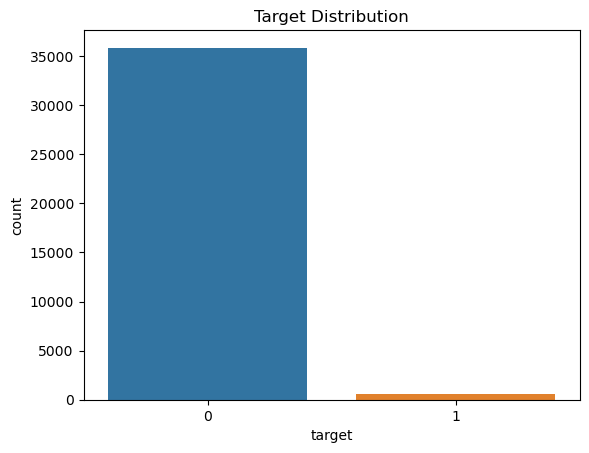

In [16]:
sns.countplot(data=df, x='target').set_title('Target Distribution');

Terlihat pada gambar, proporsi dari target (default) terlihat tidak seimbang artinya pada proses selanjutnya membutuhkan proses uspampling atau downsampling pada data.

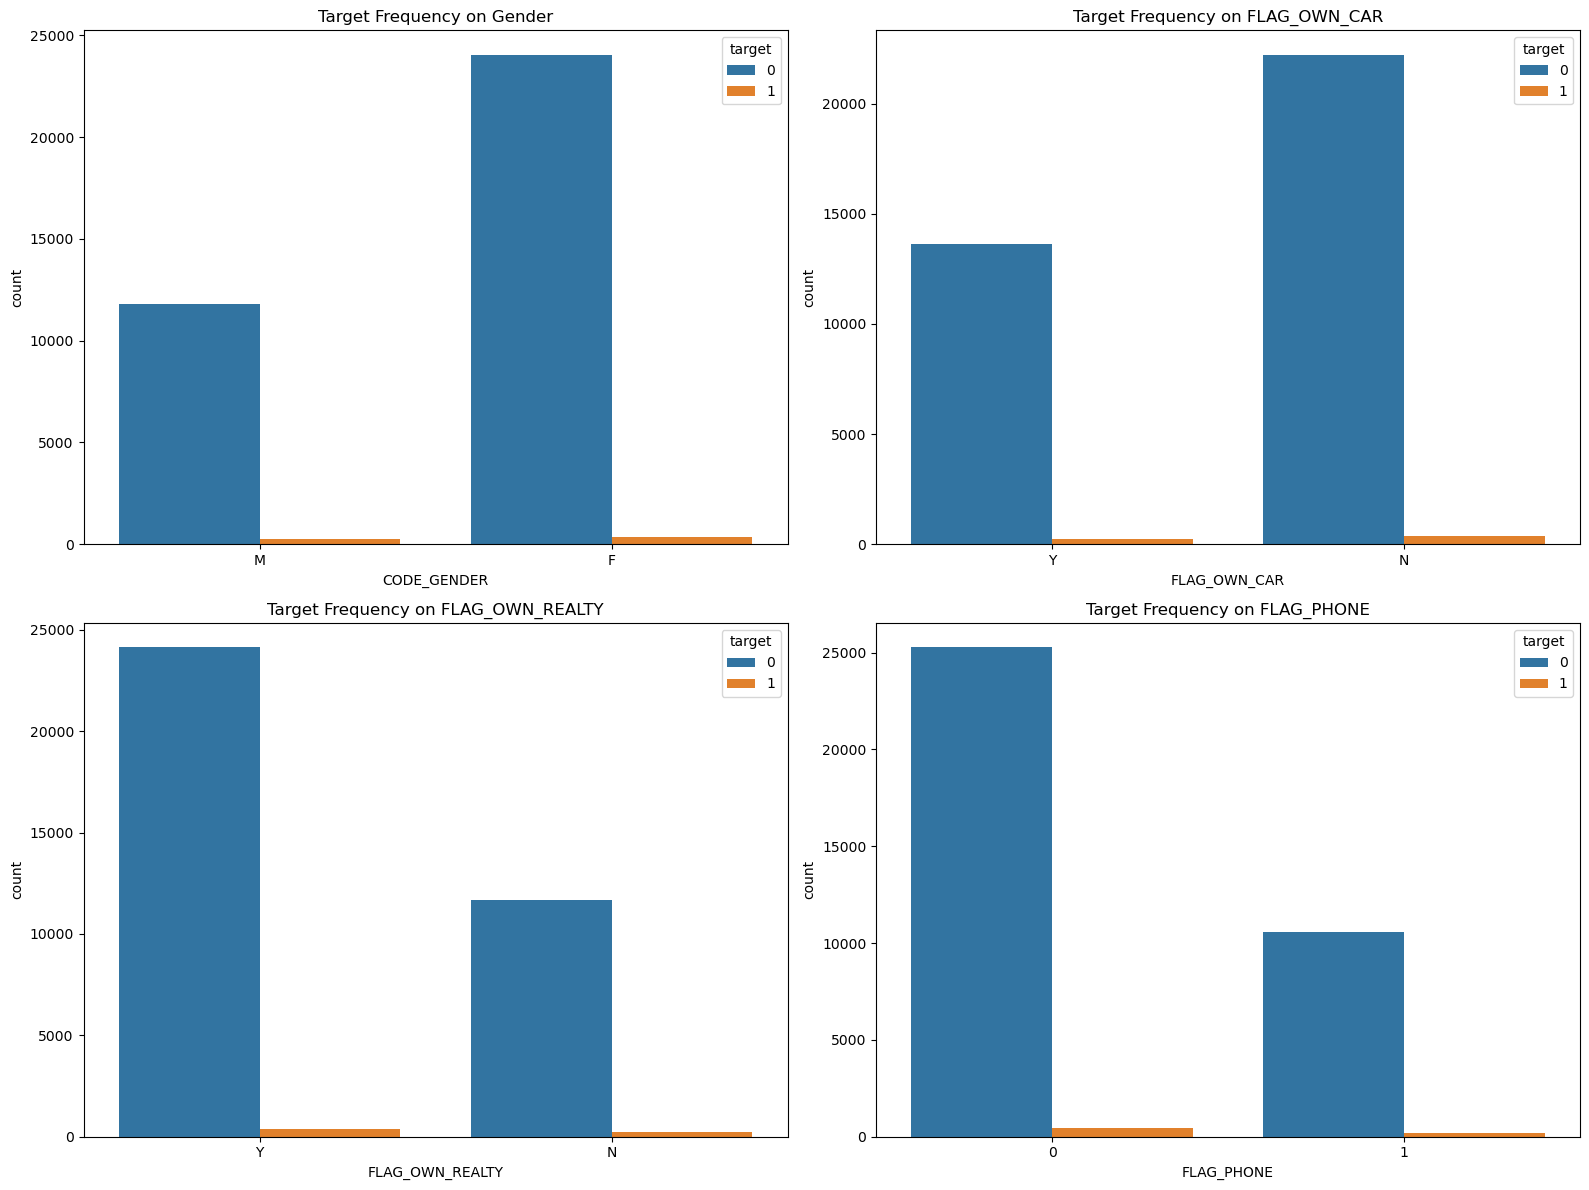

In [17]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

sns.countplot(data=df, x='CODE_GENDER', hue='target', ax=axes[0,0]).set_title('Target Frequency on Gender')
sns.countplot(data=df, x='FLAG_OWN_CAR', hue='target', ax=axes[0,1]).set_title('Target Frequency on FLAG_OWN_CAR')
sns.countplot(data=df, x='FLAG_OWN_REALTY', hue='target', ax=axes[1,0]).set_title('Target Frequency on FLAG_OWN_REALTY')
sns.countplot(data=df, x='FLAG_PHONE', hue='target', ax=axes[1,1]).set_title('Target Frequency on FLAG_PHONE')

plt.tight_layout()

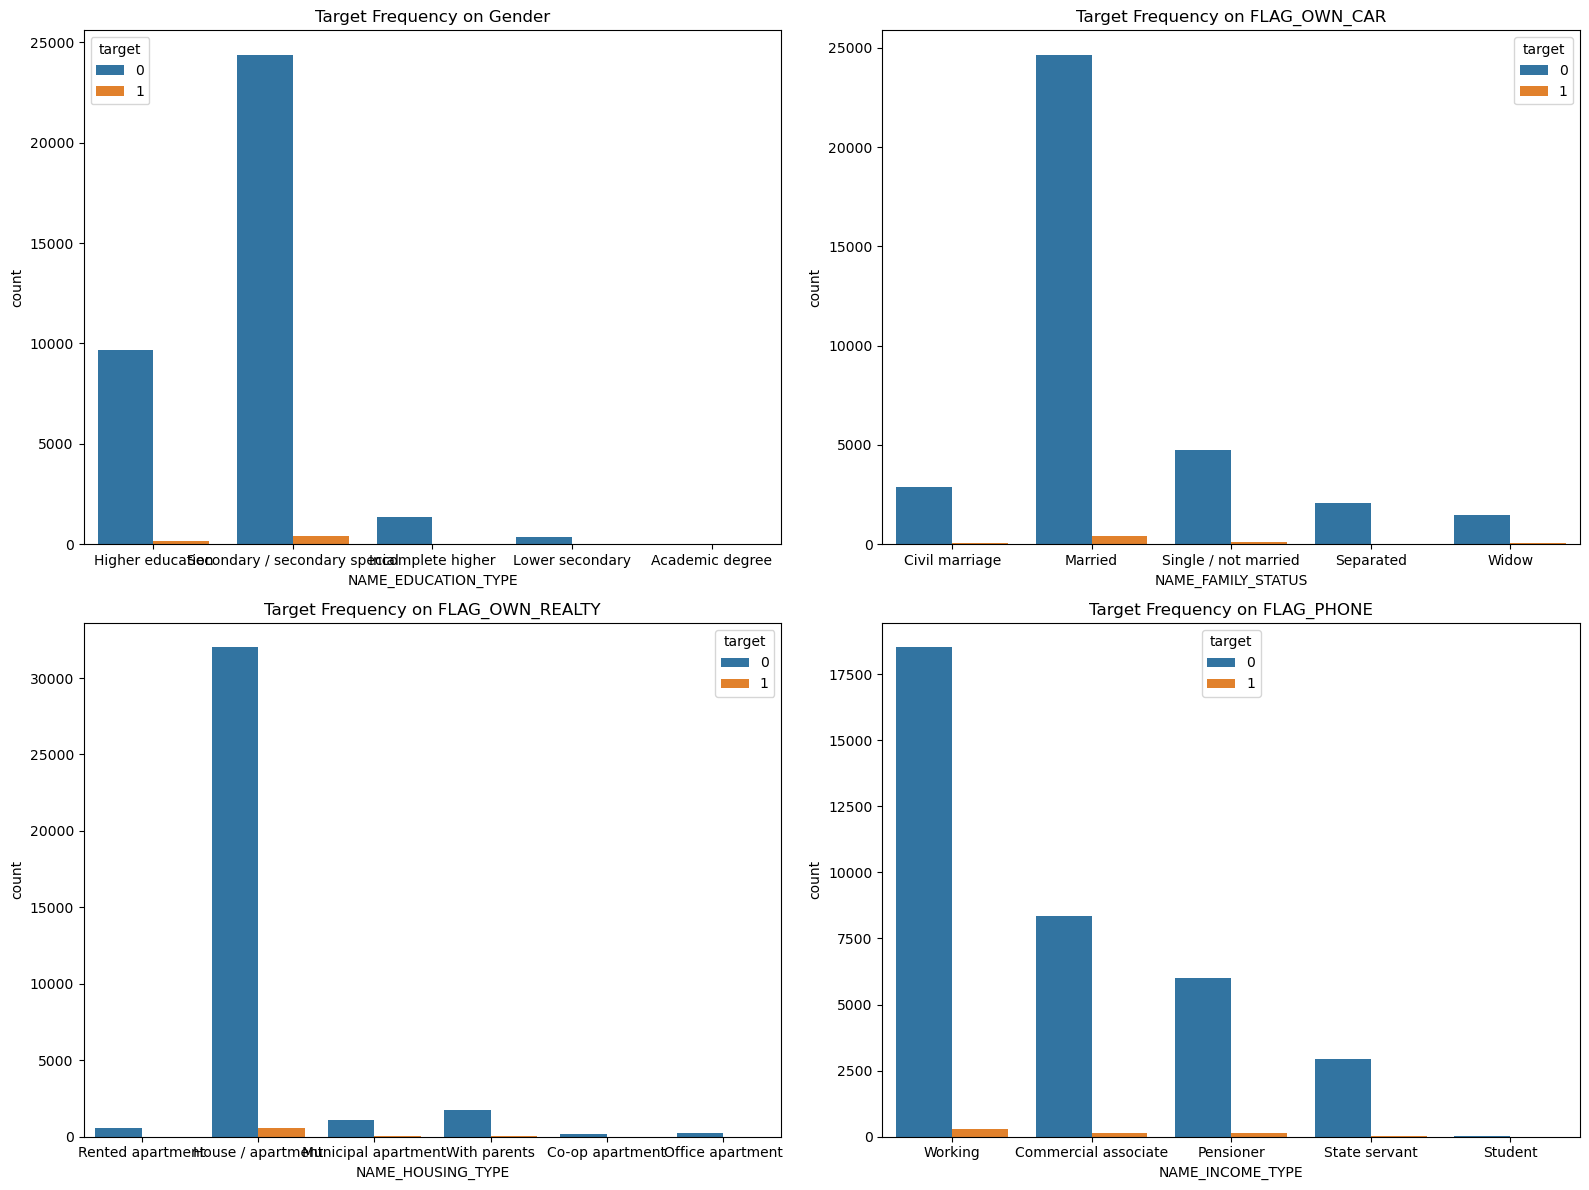

In [18]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

sns.countplot(data=df, x='NAME_EDUCATION_TYPE', hue='target', ax=axes[0,0]).set_title('Target Frequency on Gender')
sns.countplot(data=df, x='NAME_FAMILY_STATUS', hue='target', ax=axes[0,1]).set_title('Target Frequency on FLAG_OWN_CAR')
sns.countplot(data=df, x='NAME_HOUSING_TYPE', hue='target', ax=axes[1,0]).set_title('Target Frequency on FLAG_OWN_REALTY')
sns.countplot(data=df, x='NAME_INCOME_TYPE', hue='target', ax=axes[1,1]).set_title('Target Frequency on FLAG_PHONE')

plt.tight_layout()

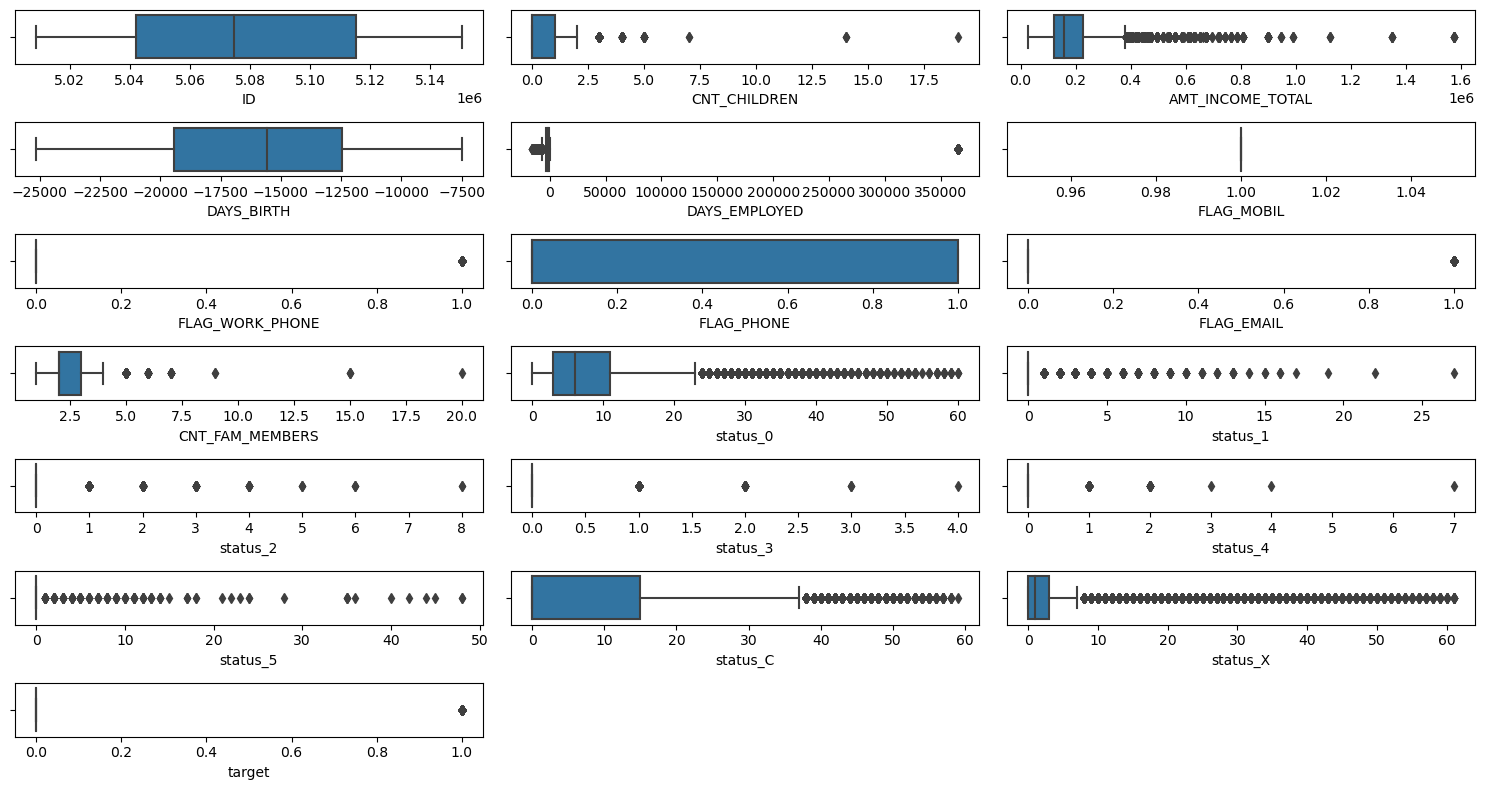

In [19]:
plt.figure(figsize=(15,8))

plotnumber = 1
for kolom in df.describe().columns:

    plt.subplot(7,3, plotnumber)
    sns.boxplot(data=df, x=kolom)

    plotnumber += 1
    
plt.tight_layout()


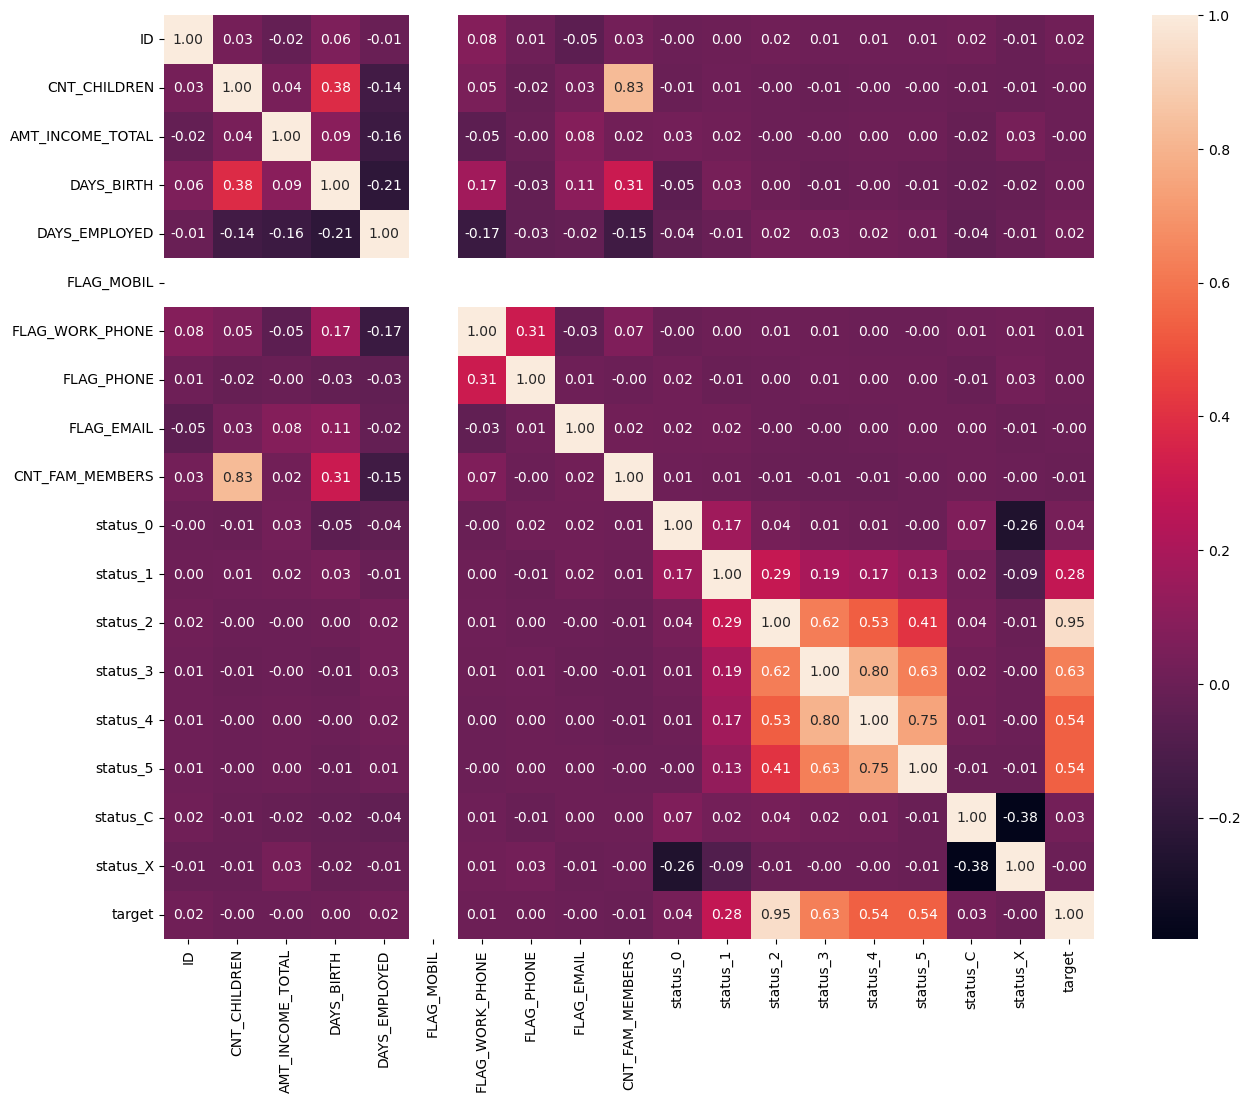

<Figure size 640x480 with 0 Axes>

In [20]:
## CORRELATION TEST with Spearman (because outliers detected)
plt.figure(figsize=(15,12))
sns.heatmap(df.corr('spearman'),annot=True, fmt='.2f')
plt.show()
plt.tight_layout()


In [21]:
df.FLAG_MOBIL.value_counts()

# karena kolom flag mobil hanya terdiri dari 1 data, maka data tersebut dihapus aja karena tidak akan berpengaruh kedalam output

1    36457
Name: FLAG_MOBIL, dtype: int64

In [22]:
df = df.drop(columns='FLAG_MOBIL')

In [23]:
# df.to_csv('cleaned-data.csv', index=False)

# Convert String / Object to Category

In [24]:
# Kolom / Fitur dengan tipe data object / string
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE


In [25]:
# convert menjadi tipe data category
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   36457 non-null  int64   
 1   CODE_GENDER          36457 non-null  category
 2   FLAG_OWN_CAR         36457 non-null  category
 3   FLAG_OWN_REALTY      36457 non-null  category
 4   CNT_CHILDREN         36457 non-null  int64   
 5   AMT_INCOME_TOTAL     36457 non-null  float64 
 6   NAME_INCOME_TYPE     36457 non-null  category
 7   NAME_EDUCATION_TYPE  36457 non-null  category
 8   NAME_FAMILY_STATUS   36457 non-null  category
 9   NAME_HOUSING_TYPE    36457 non-null  category
 10  DAYS_BIRTH           36457 non-null  int64   
 11  DAYS_EMPLOYED        36457 non-null  int64   
 12  FLAG_WORK_PHONE      36457 non-null  int64   
 13  FLAG_PHONE           36457 non-null  int64   
 14  FLAG_EMAIL           36457 non-null  int64   
 15  OCCUPATION_TYPE    

Semua data string / object telah diubah menjadi data tipe category, selanjutnya adalah mengubahnya kedalam bentuk numerik.

In [27]:
# Turn categorical variables into numbers
for label, content in df.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # We add the +1 because pandas encodes missing categories as -1
        df[label] = pd.Categorical(content).codes+1
        
# codes+1, digunakan agar seluruh tipe data bernilai positif, karena seperti yang diketahui bahwa tipe data NAN akan dikonversikan menjadi -1 secara default berdasarkan pandas category

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  int8   
 2   FLAG_OWN_CAR         36457 non-null  int8   
 3   FLAG_OWN_REALTY      36457 non-null  int8   
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  int8   
 7   NAME_EDUCATION_TYPE  36457 non-null  int8   
 8   NAME_FAMILY_STATUS   36457 non-null  int8   
 9   NAME_HOUSING_TYPE    36457 non-null  int8   
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  FLAG_EMAIL           36457 non-null  int64  
 15  OCCUPATION_TYPE      36457 non-null 

Seluruh data telah diubah menjadi tipe data kategorikal, untuk missing values pada kolom OCCUPATION_TYPE, akan dibiarkan saja menjadi data NaN. dan akan menjadi kategori sendiri yaitu data NaN.

# Modeling

## Data Splitting

In [29]:
# define X y
X = df.drop(columns=['ID', 'target', 'status_0', 'status_1', 'status_2', 'status_3', 'status_4', 'status_5','status_C', 'status_X'])
y = df['target'] 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Preprocessing

In [31]:
transformer = ColumnTransformer([
    ('scaler', RobustScaler(), ['CODE_GENDER','FLAG_OWN_CAR',
 'FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_WORK_PHONE',
 'FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                  'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
                                  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
                                  'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                                  'CNT_FAM_MEMBERS'])])

## Benchmark Model

In [32]:
# Looping Funcion

forest = RandomForestClassifier()
# logreg = LogisticRegression()
boost = XGBClassifier()

list_algo = [forest, boost]
list_score = []
list_mean = []
list_std = []

for algo in list_algo:

    model = algo

    # pipeline berisi preprocessing dan modeling
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    cv_score = cross_val_score(
        estimator= pipe_model,
        X= X_train,
        y= y_train,
        cv= 5,
        scoring='recall'
    )

    list_score.append(cv_score.round(1))
    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std())

In [33]:
df_cv = pd.DataFrame({
    'algo': list_algo,
    'mean': list_mean,
    'std': list_std,
    'all_score': list_score
})

df_cv

,algo,mean,std,all_score
0,RandomForestClassifier(),0.139992,0.029877,"[0.1, 0.2, 0.2, 0.1, 0.2]"
1,"XGBClassifier(base_score=None, booster=None, c...",0.095300,0.032386,"[0.1, 0.1, 0.1, 0.1, 0.1]"


In [34]:
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7169
           1       0.48      0.23      0.31       123

    accuracy                           0.98      7292
   macro avg       0.73      0.61      0.65      7292
weighted avg       0.98      0.98      0.98      7292



In [35]:
boost.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7169
           1       0.48      0.23      0.31       123

    accuracy                           0.98      7292
   macro avg       0.73      0.61      0.65      7292
weighted avg       0.98      0.98      0.98      7292



Terlihat berdasarkan akurasi, kedua model menghasilkan tingkat akurasi yang sangat baik. Namun perlu di ingat bahwa kita belum melakukan oversampling / undersampling terhadap data. dan juga untuk kasus ini metric yang akan diandalkan adalah Recall.

## Dealing with Imbalanced Data

**Random Under-Sampling**

In [36]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 28672), (1, 28672)]


Proporsi Total data setelah dilakukan Random Under Sampling menjadi seimbang. Selanjutnya kita akan menggunakan data yang telah di seimbangkan.

In [37]:
### both will have same shape
X_test.shape, y_test.shape

((7292, 16), (7292,))

**Random Forest**

In [38]:
ros_model = forest.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.23      0.44      0.30       123

    accuracy                           0.97      7292
   macro avg       0.61      0.71      0.64      7292
weighted avg       0.98      0.97      0.97      7292



**XGBoost**

In [39]:
ros_model = boost.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.19      0.48      0.27       123

    accuracy                           0.96      7292
   macro avg       0.59      0.72      0.63      7292
weighted avg       0.98      0.96      0.97      7292



Berdasarkan eksperimen yang telah dilakukan dengan menggunakan Random Over Sampling dalam mengadapi permalasahan imbalance data. Didapatkan bahwa terdapat peningkatan nilai recall pada kedua model.

## Hyperparameter

**Random Forest**

In [40]:
from sklearn.model_selection import RandomizedSearchCV

In [41]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
param = {"n_estimators": np.arange(1, 21),
         "max_depth": np.arange(1,32)}

rs_model = RandomizedSearchCV(RandomForestClassifier(),
                              param_distributions=param,
                              n_iter=100,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train_ros, y_train_ros)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 2min 12s
Wall time: 2min 12s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
                   verbose=True)

In [42]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 10, 'max_depth': 31}

In [43]:
%%time
# Best hyperparameters
tuning_param = RandomForestClassifier(n_estimators= 16,
                                      max_depth=30,
                                      n_jobs=-1)

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
ros_model = tuning_param.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.23      0.44      0.30       123

    accuracy                           0.97      7292
   macro avg       0.61      0.71      0.64      7292
weighted avg       0.98      0.97      0.97      7292



**XGBoost**

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
param = {"n_estimators": np.arange(1, 200),
         "max_depth": np.arange(1,9),
         "learning_rate": np.arange(0.01,1),
         "n_jobs": [-1]}

rs_model = RandomizedSearchCV(XGBClassifier(),
                         param_distributions=param,
                         n_iter=100,
                         cv=5,
                         verbose=True)

rs_model.fit(X_train_ros, y_train_ros)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 1h 1min 34s
Wall time: 5min 35s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199]),
                                        'n_jobs': [-1]},
                   verbose=True)

In [47]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_jobs': -1, 'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.01}

In [48]:
%%time
# Best hyperparameters
tuning_param = XGBClassifier(n_estimators= 198,
                             max_depth=8,
                             learning_rate=0.01,
                             n_jobs=-1)

CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
ros_model = tuning_param.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7169
           1       0.06      0.53      0.10       123

    accuracy                           0.85      7292
   macro avg       0.52      0.69      0.51      7292
weighted avg       0.97      0.85      0.90      7292



In [50]:
# Fit an instance of Random Forest
tuning_param.fit(X_train_ros, y_train_ros);

In [51]:
tuning_param.feature_importances_

array([0.03441943, 0.0612772 , 0.06385972, 0.05212297, 0.06411927,
       0.06622343, 0.06406798, 0.06065151, 0.05523587, 0.08251898,
       0.07941995, 0.05628639, 0.07023377, 0.05160962, 0.06685533,
       0.07109863], dtype=float32)

In [52]:
# Match features to columns
features_dict = dict(zip(X.columns, list(tuning_param.feature_importances_)))
features_dict

{'CODE_GENDER': 0.03441943,
 'FLAG_OWN_CAR': 0.061277196,
 'FLAG_OWN_REALTY': 0.063859716,
 'CNT_CHILDREN': 0.052122973,
 'AMT_INCOME_TOTAL': 0.06411927,
 'NAME_INCOME_TYPE': 0.06622343,
 'NAME_EDUCATION_TYPE': 0.06406798,
 'NAME_FAMILY_STATUS': 0.060651515,
 'NAME_HOUSING_TYPE': 0.05523587,
 'DAYS_BIRTH': 0.08251898,
 'DAYS_EMPLOYED': 0.07941995,
 'FLAG_WORK_PHONE': 0.056286395,
 'FLAG_PHONE': 0.07023377,
 'FLAG_EMAIL': 0.05160962,
 'OCCUPATION_TYPE': 0.06685533,
 'CNT_FAM_MEMBERS': 0.07109863}

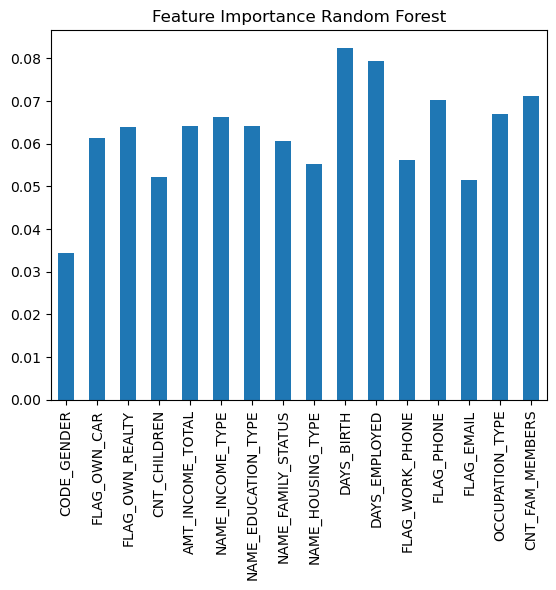

In [53]:
# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance Random Forest", legend=False);

In [54]:
# Fit an instance of XGBoost
tuning_param.fit(X_train_ros, y_train_ros);

In [55]:
tuning_param.feature_importances_

array([0.03441943, 0.0612772 , 0.06385972, 0.05212297, 0.06411927,
       0.06622343, 0.06406798, 0.06065151, 0.05523587, 0.08251898,
       0.07941995, 0.05628639, 0.07023377, 0.05160962, 0.06685533,
       0.07109863], dtype=float32)

In [56]:
# Match features to columns
features_dict = dict(zip(X.columns, list(tuning_param.feature_importances_)))
features_dict

{'CODE_GENDER': 0.03441943,
 'FLAG_OWN_CAR': 0.061277196,
 'FLAG_OWN_REALTY': 0.063859716,
 'CNT_CHILDREN': 0.052122973,
 'AMT_INCOME_TOTAL': 0.06411927,
 'NAME_INCOME_TYPE': 0.06622343,
 'NAME_EDUCATION_TYPE': 0.06406798,
 'NAME_FAMILY_STATUS': 0.060651515,
 'NAME_HOUSING_TYPE': 0.05523587,
 'DAYS_BIRTH': 0.08251898,
 'DAYS_EMPLOYED': 0.07941995,
 'FLAG_WORK_PHONE': 0.056286395,
 'FLAG_PHONE': 0.07023377,
 'FLAG_EMAIL': 0.05160962,
 'OCCUPATION_TYPE': 0.06685533,
 'CNT_FAM_MEMBERS': 0.07109863}

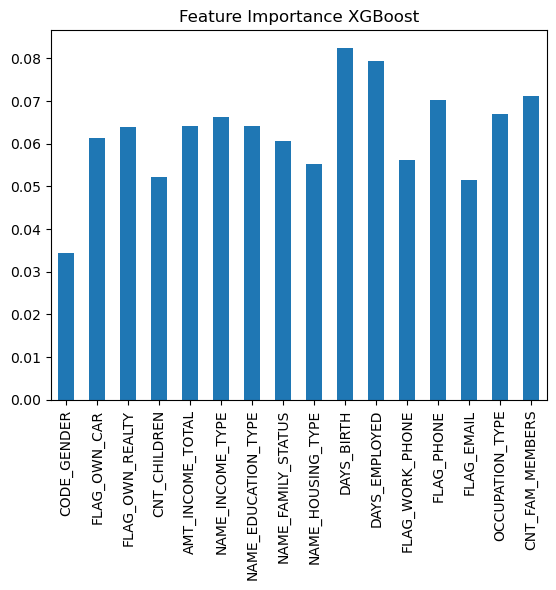

In [57]:
# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance XGBoost", legend=False);

# Kesimpulan

|Model||Recall|
|-----||--------|
|Random forest Algorithm||49%|
|XGBoost Classifier||54%|

- Pada projek ini Recall dijadikan sebagai metric evaluasi, karena di projek ini bertujuan untuk meminimalisir hasil prediksi yang data aktualnya default namun terprediksi sebagai non default.
- Model dengan algoritma XGBoost menghasilkan nilai recall lebih besar ketimbang Model dengan algoritma Random Forest Classifier.